### Retrieval-Augmented Generation (RAG) - Query Translation -  Decomposition
**Problem:** User queries are challenging. If user provides an ambiguous query, they will get ambiguous matches. 
             LLMs just follow what was in the context and produce the results as it is.

**Solution:** There are multiple ways to tackle the above problem.

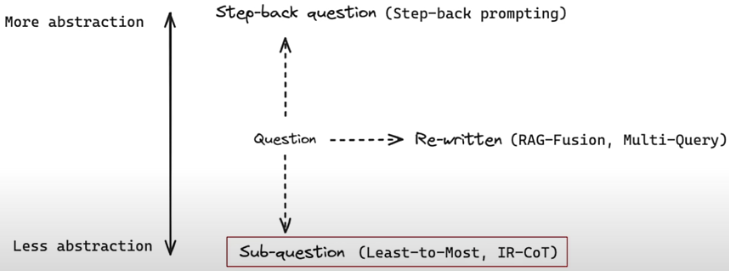
             
- More Abstraction: Refers to generalizing or stepping back to view the question from a higher-level perspective.
  - Example: Instead of directly asking for a specific answer, you might frame a question like, "What broader concepts should I consider for this problem?"
- Less Abstraction: Refers to breaking the question into specific, granular sub-questions that are easier to answer..
  - Example: For the question, "How does climate change affect agriculture?" sub-questions might be:
    - "What is climate change?"
    - "What are the main impacts of climate change on crop growth?"
- Rewriting the query using RAG-Fusion or Multi-Query
  - **RAG-Fusion**: Combining retrieved documents or information from multiple sources to provide a more comprehensive context.
  - **Multi-Query**: Generating multiple variations of the question to improve the chances of retrieving relevant information.
  - **Decomposition**: Breaking down a complex query into smaller sub-queries to improve the retrieval process. 

This section discusses on **Decomposition**, a Query Translation in RAG.

##### Key Highlights:
- **Implement Decomposition Query Translation**
  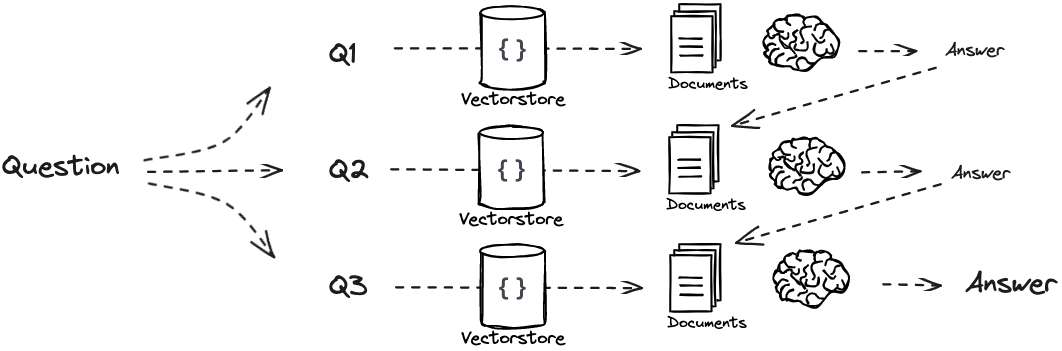
  - The query is broke into smaller sub-queries to improve the retrieval process.
    - For Example: "What are the symptoms of diabetes, and how is it treated?" can be split into:
      - Sub-query 1: "What are the symptoms of diabetes?"
      - Sub-query 2: "How is diabetes treated?" 
  - As shown in the figure, the answer to the first question is estimated from LLM. This question answer pair is appended to the next one and passed to LLM along with the context and question and gets question-answer pair. This continues until all sub-queries are retrieved.
  
##### Papers:

* https://arxiv.org/pdf/2205.10625.pdf
* https://arxiv.org/abs/2212.10509.pdf
  

##### What's Next: 


#### Install required libraries

In [1]:
# Install required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import required libraries

In [2]:
import os # Operating system relevant tasks
from dotenv import load_dotenv
import bs4 # Import Beautiful Soap, a Python Web Scrapping package
from langchain_community.document_loaders import WebBaseLoader # Load documents from website
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma # Import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain import hub # Python library containing pre-defined Prompts, Chains for LLM applications
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
import numpy as np
from langchain.load import dumps, loads
from operator import itemgetter

USER_AGENT environment variable not set, consider setting it to identify your requests.


#### Environment Setup

In [3]:
# Load environment variables from .env file
load_dotenv()

# API key provides authentication to access LangChain service 
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # Enables LangChain Tracing V2, a mechanism to enable and monitor the execution of LangChain applications for debugging and optimization
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com' # Configures the LangChain API End Point to use LangChain for tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
# API key to access OpenAI services
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

#### RAG Process

##### Load, Split, Index

In [4]:
## Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load() 

## Split the documents based on tokens
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)
splits = text_splitter.split_documents(blog_docs)

## Calculate the vector embeddings of the splits, store in the vector store and convert the vector store into a retriever object
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings()) # Store the vector embeddings of splits in Chroma DB

## Retrieve the documents that are closing matching with prompt using KNN
retriever = vectorstore.as_retriever(search_kwargs={"k": 5}) 

#### **Prompt - Generate sub-queries**
Write a Prompt in such a way that the query is converted into sub-queries utilizing the capability of LLM model

In [5]:
# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

# Chain
generate_queries_decomposition = (
    prompt_decomposition 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

# Display sub-queries
for sub_question in questions:
    print(sub_question)

1. What is LLM technology and how does it work in autonomous agent systems?
2. What are the specific components that make up an autonomous agent system powered by LLM?
3. How do the main components of an LLM-powered autonomous agent system interact with each other to achieve autonomy?


#### LLM, Invoke

The prompt template defines a question, sub-queries and collected documents from the retrieval.

In [6]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

Answer for each sub-question is estimated from the LLM. Question-Answer pairs are extracted.

In [7]:
def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [8]:
# Get the question-answer pairs
q_a_pairs

"\n---\nQuestion: 1. What is LLM technology and how does it work in autonomous agent systems?\nAnswer: LLM stands for Large Language Model, which serves as the core controller in autonomous agent systems. In these systems, LLM functions as the agent's brain and is complemented by key components such as planning, subgoal decomposition, reflection, and refinement. LLM-powered autonomous agents break down large tasks into smaller subgoals to efficiently handle complex tasks. They can also engage in self-criticism, self-reflection, and learning from past actions to improve the quality of their results. Additionally, some approaches involve using external classical planners for long-horizon planning, where LLM translates the problem into a planning language, requests a classical planner to generate a plan, and then translates the plan back into natural language. Overall, LLM technology in autonomous agent systems enables agents to solve problems, plan ahead, and improve iteratively through 

**Traces:**
- Question 1: https://smith.langchain.com/o/95ec3361-391f-51b4-a485-c9c13112a6dc/projects/p/e1ee0c50-fde4-4d12-849f-c9929ba57c69?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=bf59bed3-d319-44a6-9e8d-633f5876a2e8
- Question 2: https://smith.langchain.com/o/95ec3361-391f-51b4-a485-c9c13112a6dc/projects/p/e1ee0c50-fde4-4d12-849f-c9929ba57c69?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=0271de90-d933-4371-832a-2e74bc812da5
- Question 3: https://smith.langchain.com/o/95ec3361-391f-51b4-a485-c9c13112a6dc/projects/p/e1ee0c50-fde4-4d12-849f-c9929ba57c69?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=d1dbf3ab-d7db-46c8-b1c1-a99287999901

In [9]:
# Get the final answer
answer

"In an LLM-powered autonomous agent system, the main components interact with each other in a coordinated manner to achieve autonomy. \n\n1. **Planning**: The agent breaks down large tasks into smaller, manageable subgoals through techniques like Chain of Thought and Tree of Thoughts. This allows for efficient handling of complex tasks by dividing them into simpler steps.\n\n2. **Subgoal Decomposition**: By decomposing hard tasks into smaller and simpler steps, the agent can enhance its model performance. Techniques like Chain of Thought and Tree of Thoughts help in transforming big tasks into multiple manageable tasks, shedding light on the model's thinking process.\n\n3. **Reflection and Refinement**: The agent engages in self-criticism and self-reflection over past actions, learning from mistakes, and refining them for future steps. This iterative process helps in improving the quality of final results by correcting errors and making better decisions.\n\n4. **External Classical Plan

**Few Takeaways:**

Techniques used for Query Decomposition:
- Rule-based Methods:
    - Predefined patterns or templates are used to split queries. For example, conjunctions like "and," "or," or question delimiters are clues for decomposition.
- Machine Learning Models:
    - NLP models trained on question decomposition datasets identify logical segments of a query automatically.
- Graph-based Parsing:
    - Dependency parsing and semantic graph construction can identify sub-components of a query.

#### Another method of decomposition is Answering Individually
Question answer pairs of all sub-queries are generated in parallel and sent as context along with main question as the question to invoke the LLM.

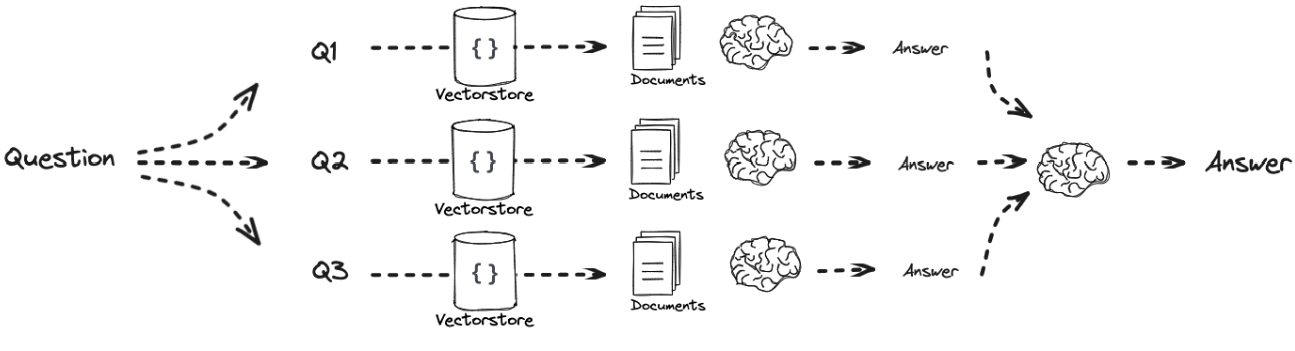